In [28]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math

plt.style.use('fivethirtyeight')

In [29]:
st.title("Stock Market Volatility Predictor")

ticker = st.text_input("Enter the ticker(AMZN, BTC-USD,...): ")
start_date = st.text_input("Enter the start date(YYYY-MM-DD): ")
end_date = st.text_input("Enter the end date(YYYY-MM-DD): ")
tickers_list = [ticker]

if start_date > end_date:
    st.write("Invalid date range. Start date must be befor end date.")
else:
    stock_data = yf.download(tickers_list, threads= False, start=start_date, end=end_date)

2023-01-20 00:15:26.727 
  command:

    streamlit run c:\Users\GerphozPC\miniconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- : No timezone found, symbol may be delisted


In [30]:
stock_data = stock_data[['Close']]
stock_data_array = stock_data.values

stock_data.head()

,Close
Date,


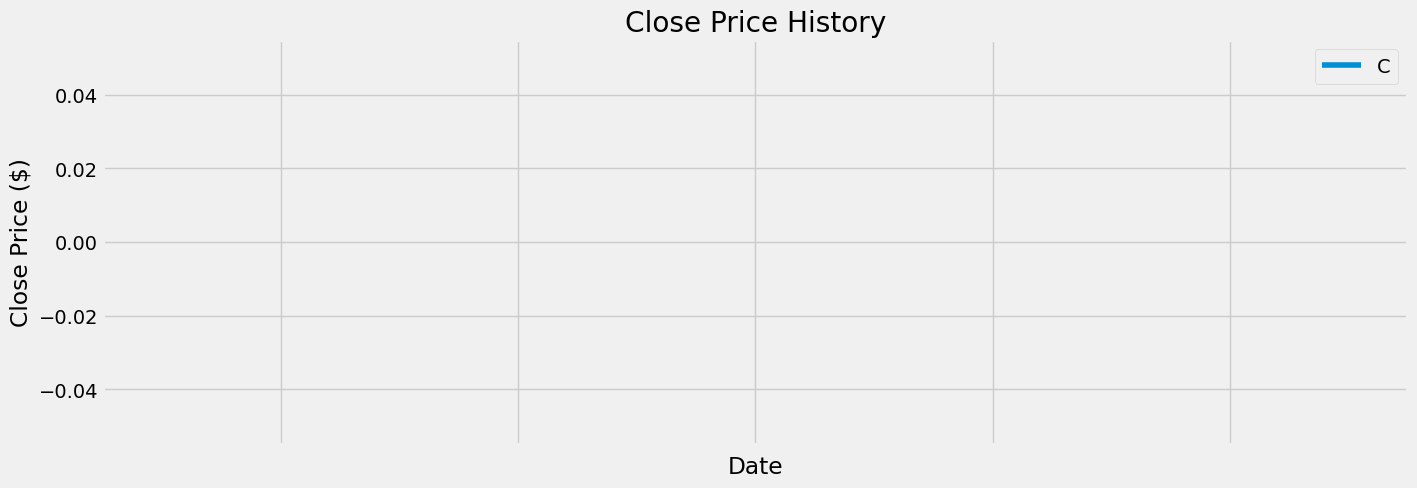

In [31]:
stock_data['Close'].plot(figsize=(15,5), legend=True)
plt.legend('Close Price @Apple')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [ ]:
st.line_chart(stock_data['Close'])
st.write("Close Price History")

In [7]:
# Scale the data using the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np.array(stock_data).reshape(-1,1))

In [8]:
x_train, y_train = [], []
for i in range(120, len(scaled)):
    x_train.append(scaled[i-120:i])
    y_train.append(scaled[i])

In [9]:
train_size = math.ceil(len(stock_data)*0.8)
test_size = len(scaled) - train_size

In [10]:
#Splitting data between train and test
sd_train, sd_test = scaled[0:train_size,:], scaled[train_size:len(scaled),:1]

In [11]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 50))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 120, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile and fit the model
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
91/91 [==============================] - 8s 51ms/step - loss: 0.0113 - accuracy: 3.4483e-04
Epoch 2/25
91/91 [==============================] - 4s 47ms/step - loss: 7.9806e-04 - accuracy: 3.4483e-04
Epoch 3/25
91/91 [==============================] - 4s 47ms/step - loss: 7.8187e-04 - accuracy: 3.4483e-04
Epoch 4/25
91/91 [==============================] - 4s 48ms/step - loss: 7.2743e-04 - accuracy: 3.4483e-04
Epoch 5/25
91/91 [==============================] - 4s 46ms/step - loss: 7.9803e-04 - accuracy: 3.4483e-04
Epoch 6/25
91/91 [==============================] - 4s 47ms/step - loss: 6.5092e-04 - accuracy: 3.4483e-04
Epoch 7/25
91/91 [==============================] - 4s 46ms/step - loss: 7.9378e-04 - accuracy: 3.4483e-04
Epoch 8/25
91/91 [==============================] - 4s 46ms/step - loss: 5.8070e-04 - accuracy: 3.4483e-04
Epoch 9/25
91/91 [==============================] - 4s 45ms/step - loss: 5.3155e-04 - accuracy: 3.4483e-04
Epoch 10/25
91/91 [======================

In [14]:
test_data = scaled[train_size-120:, :]
x_test = []
y_test = stock_data_array[train_size:, :]
for i in range(120, len(test_data)):
    x_test.append(test_data[i-120:i])

x_test = np.array(x_test)

In [16]:
# Make predictions on the test set
prediction = model.predict(x_test)

# Scale the data back to its original form
prediction = scaler.inverse_transform(prediction)
y_test = scaler.inverse_transform(y_train)

19/19 [==============================] - 1s 17ms/step


In [17]:
# Calculate the model's accuracy
accuracy = model.evaluate(x_train, y_train, verbose = 0)
print("Accuracy: ", accuracy)

Accuracy:  [0.00019277616229373962, 0.00034482759656384587]


In [18]:
train = stock_data[:train_size]
close_pred = stock_data[train_size:]
close_pred['Predictions'] = prediction

C:\Users\GerphozPC\AppData\Local\Temp\ipykernel_10524\2599283666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_pred['Predictions'] = prediction


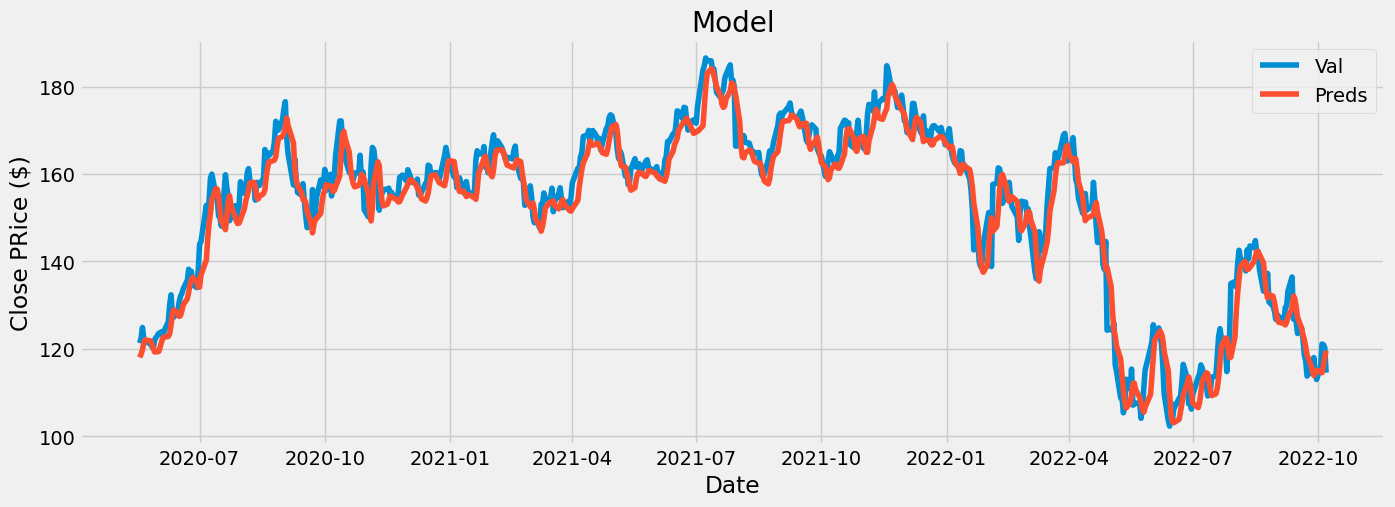

In [25]:
plt.figure(figsize=(15,5))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close PRice ($)')
plt.plot(close_pred[['Close', 'Predictions']])
plt.legend(['Val', 'Preds'])
plt.show()